In [4]:
import gym
import minerl
import logging
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pathlib import Path
import collections
import pickle
import torch.nn.functional as F
import math
from tqdm import tqdm
from itertools import product
from collections import OrderedDict
import copy
import torch.nn.utils as torch_utils
from copy import deepcopy
from action_manager import ActionManager

logging.disable(logging.ERROR)

In [2]:
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frames.append(frame)
    cap.release()
    return frames

def get_and_format_data(path_list):
    all_data = []

    for i, path in enumerate(path_list):
        action_values = np.load(path + "/rendered.npz", allow_pickle=True)
        min_len = len(action_values['reward'])

        frames = extract_frames(path + "/recording.mp4")
        frames = frames[:min_len]

        aligned_data = [(frames[i], {k: v[i] for k, v in action_values.items()}) for i in range(min_len)]

        aligned_data = aligned_data[:((len(aligned_data) // 128) * 128)]
        all_data.append(aligned_data)

    return all_data


In [3]:
directory_path = Path("MineRLTreechop-v0/")
path_list = ["MineRLTreechop-v0/" + f.name for f in directory_path.iterdir()]

data = get_and_format_data(path_list)

In [9]:

print(f"Amount of episodes: {len(data)}")
print(f"\nEach element in each episode is of form: (frames, action-value dict)")
print(f"Shape of pov frame: {data[0][0][0].shape}")

print("\nActions:")
for key in data[0][0][1].keys():
    print("  " + key)

Amount of episodes: 210

Each element in each episode is of form: (frames, action-value dict)
Shape of pov frame: (64, 64, 3)

Actions:
  reward
  action$forward
  action$left
  action$back
  action$right
  action$jump
  action$sneak
  action$sprint
  action$attack
  action$camera


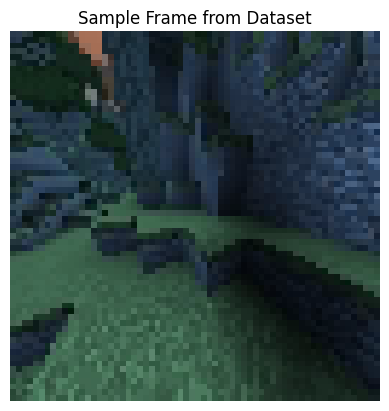

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


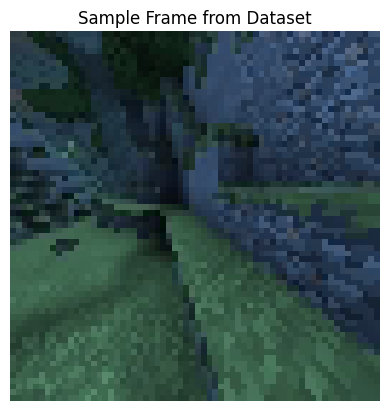

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


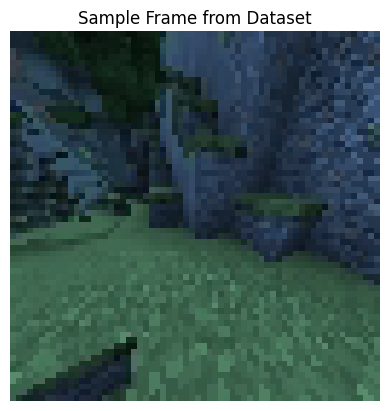

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


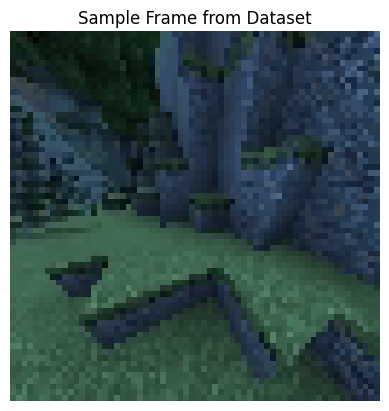

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


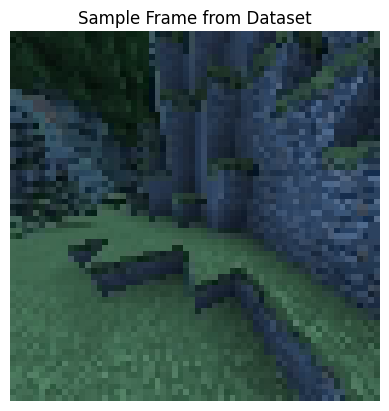

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


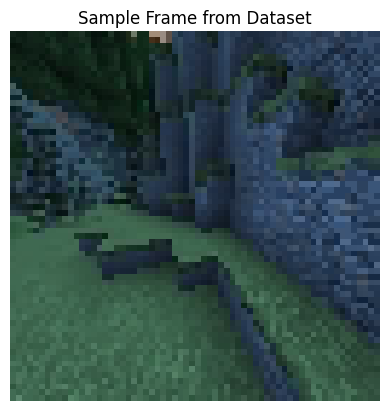

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(1), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


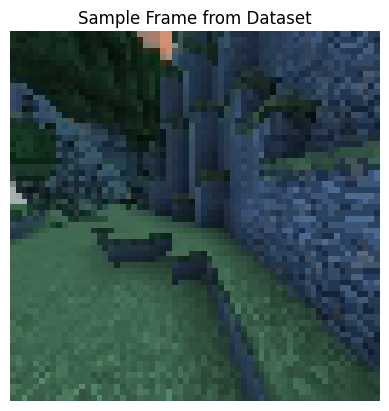

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(1), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


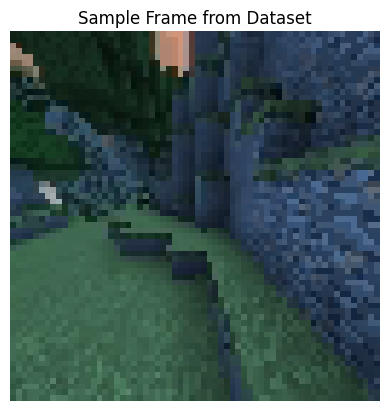

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(1), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


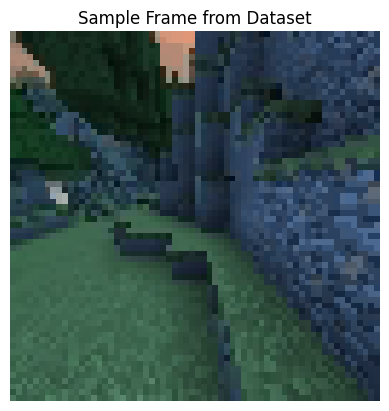

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([-11.25,   0.  ], dtype=float32)}


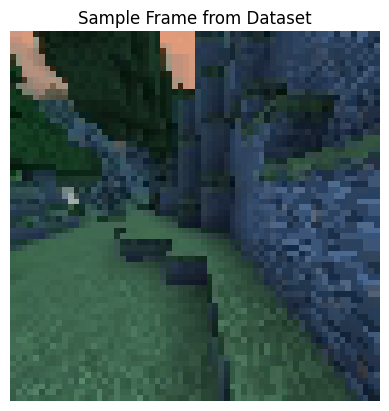

{'reward': np.float32(0.0), 'action$forward': np.int64(1), 'action$left': np.int64(0), 'action$back': np.int64(0), 'action$right': np.int64(0), 'action$jump': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0), 'action$attack': np.int64(0), 'action$camera': array([0., 0.], dtype=float32)}


In [ ]:
for idx in range(20, 30):
    plt.imshow(data[0][idx][0])
    plt.title("Sample Frame from Dataset")
    plt.axis("off")
    plt.show()
    print(data[0][idx][1])

In [10]:
with open("video_and_actions.pkl", "wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open("video_and_actions.pkl", "rb") as f:
    data = pickle.load(f)

# data = data[:250000]
print(len(data))

340147


In [25]:
class Data:
    def __init__(self, size):
        self.index = 0
        self.size = size
        self.full = False
        self.data = np.array([None] * size)
        self.last_reward_index = 0

    def current_size(self):
        return self.size if self.full else self.index

    def append(self, data):
        assert not self.full
        self.data[self.index] = data
        self.index += 1
        self.full = (self.index == self.size)

    def get(self, data_index):
        return self.data[data_index % self.size]

    def update_last_reward_index(self):
        assert not self.full
        self.last_reward_index = self.index

    def remove_new_data(self):
        assert not self.full
        removed_ids_list = list(range(self.last_reward_index, self.index))
        removed_amount = len(removed_ids_list)
        self.index = self.last_reward_index
        return removed_amount, removed_ids_list

class Transition:
    def __init__(self, state, action, reward, nonterminal):
        self.state = state
        self.action = action
        self.reward = reward
        self.nonterminal = nonterminal

class Dataset(Dataset):
    def __init__(self, device, capacity, state_shape, action_manager, scale_rewards=True):
        self.device = device
        self.capacity = capacity
        self.state_shape = state_shape

        self.blank_trans = Transition(torch.zeros(state_shape, dtype=torch.uint8), None, 0, False)

        self.discount = 1.
        self.n = 1

        self.action_manager = action_manager

        self.transitions = Data(capacity)
        self.scale_rewards = scale_rewards
        self.gatherlog_sample_id_list = []

    def reward_reshaping(self, r):
        if self.scale_rewards:
            return 1.0 if r > 0 else 0.0
        else:
            return r

    def append_sample(self, sample, done):
        frame, action_dict  = sample[0], sample[1]
        reward = action_dict['reward']

        action_id = self.action_manager.get_id(action_dict)
        torch_img = torch.from_numpy(frame).permute(2, 0, 1)
        self.transitions.append(Transition(torch_img, action_id, reward, not done))

    def update_last_reward_index(self):
        self.transitions.update_last_reward_index()

    def remove_new_data(self):
        removed_amount, removed_ids_list = self.transitions.remove_new_data()
        for id_ in removed_ids_list:
            if id_ in self.gatherlog_sample_id_list:
                self.gatherlog_sample_id_list.remove(id_)
        return removed_amount

    def get_transition(self, idx):
        transition = np.array([None] * (self.n + 1))
        transition[0] = self.transitions.get(idx)
        for t in range(1, 1 + self.n):
            if transition[t - 1].nonterminal:
                transition[t] = self.transitions.get(idx + t)
            else:
                transition[t] = self.blank_trans
        return transition

    def sample_line(self, size, length):
        
        ids = np.random.randint(0, self.transitions.current_size() - length - self.n, size=size)
        ids = [list(range(i, i + length)) for i in ids]
        ids = [item for sublist in ids for item in sublist]
        states, actions, returns, nonterminals = [], [], [], []

        for id_ in ids:
            transition = self.get_transition(id_)
            states.append(transition[0].state.to(self.device).to(dtype=torch.float32).div_(255))

            actions.append(torch.tensor([transition[0].action], dtype=torch.int64, device=self.device))
            returns.append(torch.tensor([sum(self.discount ** n * self.reward_reshaping(transition[n].reward) for n in range(self.n))],
                                         dtype=torch.float32, device=self.device))
            nonterminals.append(torch.tensor([transition[self.n].nonterminal],
                                             dtype=torch.float32, device=self.device))
        states = torch.stack(states)
        actions = torch.cat(actions)
        returns = torch.cat(returns)
        nonterminals = torch.stack(nonterminals)

        return states, actions, returns, nonterminals

In [30]:
def put_data_into_dataset(action_manager, dataset, episodes, num_frames=3, only_successful=True):
    """
    :param action_manager: An instance of your ActionManager.
    :param dataset: An instance of your Dataset class (the cyclic buffer).
    :param episodes: A list of episodes. Each episode is a list of tuples,
                     where each tuple is (frame, action_dict).
    :param num_frames: Number of consecutive timesteps over which to stack camera actions.
    :param only_successful: If True, only process episodes marked as successful.
    """
    def is_success(episode):
        # Check if the episode is marked as successful
        for _, action_dict in episode:
            if action_dict['reward'] > 0:
                return True
        return False

    def is_no_op(action_dict):
        # Determine if an action is a no-op by checking if its discrete action ID is zero.
        a_id = action_manager.get_id(action_dict)
        return a_id == 0

    def process_sample(sample, last_reward, last_episode=False):
        """
        Process a single sample (timestep) and add it to the dataset conditionally
        :param sample: A tuple (frame, action_dict)
        """
        # Extract reward from the action dictionary
        reward = sample[1].get("reward", 0.0)

        # Update last_reward if needed.
        if reward >= last_reward:
            last_reward = reward
        
        if reward != 0.0:
            dataset.append_sample(sample, last_episode)
            dataset.update_last_reward_index()
            counter_change = 1
        else:
            # Only add samples that are not pure no-op (unless it's a terminal state)
            if (not is_no_op(sample[1])) or last_episode:
                dataset.append_sample(sample, last_episode)
                counter_change = 1
            else:
                counter_change = 0
        return counter_change, last_reward

    total_trajs_counter = 0
    added_sample_counter = 0
    initial_sample_amount = dataset.transitions.current_size()

    for epi in episodes:

        if only_successful and not is_success(epi):
            print("Skipping unsuccessful episode")
            continue

        total_trajs_counter += 1
        last_reward = 0.0

        # Use a deque to stack consecutive timesteps for camera action stacking
        sample_queue = deque(maxlen=num_frames)

        for sample_idx, sample in enumerate(epi):
            sample_queue.append(sample)

            # Once we have enough samples in the queue, process the oldest one
            if len(sample_queue) == num_frames:

                # Stack camera actions from subsequent samples into the first sample
                for i in range(1, num_frames):

                    # Assume the action dictionary contains a key 'action$camera'
                    sample_queue[0][1]['action$camera'] += sample_queue[i][1].get('action$camera', [0.0, 0.0])

                    if sample_queue[i][1].get("reward", 0.0) != 0.0:
                        break  # Stop stacking if a reward is encountered

                counter_change, last_reward = process_sample(sample_queue[0], last_reward, sample_idx == len(epi) - 1)

                added_sample_counter += counter_change
                sample_queue.popleft()

        # Process any remaining samples in the queue
        for sample in sample_queue:
            counter_change, last_reward = process_sample(sample, last_reward)
            added_sample_counter += counter_change

        # Optionally ensure the last transition in the episode is marked as terminal
        if dataset.transitions.current_size() > 0:
            last_transition = copy.deepcopy(dataset.transitions.data[dataset.transitions.index - 1])

            dataset.transitions.data[dataset.transitions.index - 1] = Transition(last_transition.state, last_transition.action, last_transition.reward, False)

        sample_queue.clear()
        # print(f"Processed episode {total_trajs_counter} / {len(episodes)}, added samples: {added_sample_counter}")

    print(f"Total new transitions added: {dataset.transitions.current_size() - initial_sample_amount}")

In [31]:
class FixupResNetCNN(nn.Module):
    """source: https://github.com/unixpickle/obs-tower2/blob/master/obs_tower2/model.py"""

    class _FixupResidual(nn.Module):
        def __init__(self, depth, num_residual):
            super().__init__()
            self.conv1 = nn.Conv2d(depth, depth, 3, padding=1, bias=False)
            self.conv2 = nn.Conv2d(depth, depth, 3, padding=1, bias=False)
            for p in self.conv1.parameters():
                p.data.mul_(1 / math.sqrt(num_residual))
            for p in self.conv2.parameters():
                p.data.zero_()
            self.bias1 = nn.Parameter(torch.zeros([depth, 1, 1]))
            self.bias2 = nn.Parameter(torch.zeros([depth, 1, 1]))
            self.bias3 = nn.Parameter(torch.zeros([depth, 1, 1]))
            self.bias4 = nn.Parameter(torch.zeros([depth, 1, 1]))
            self.scale = nn.Parameter(torch.ones([depth, 1, 1]))

        def forward(self, x):
            x = F.relu(x)
            out = x + self.bias1
            out = self.conv1(out)
            out = out + self.bias2
            out = F.relu(out)
            out = out + self.bias3
            out = self.conv2(out)
            out = out * self.scale
            out = out + self.bias4
            return out + x

    def __init__(self, input_channels):
        super().__init__()
        depth_in = input_channels

        layers = []
        channel_sizes = [32, 64, 64]

        for depth_out in channel_sizes:
            layers.extend([
                nn.Conv2d(depth_in, depth_out, 3, padding=1),
                nn.MaxPool2d(3, stride=2, padding=1),
                self._FixupResidual(depth_out, 8),
                self._FixupResidual(depth_out, 8),
            ])
            depth_in = depth_out
        layers.extend([
            self._FixupResidual(depth_in, 8),
            self._FixupResidual(depth_in, 8),
        ])
        self.conv_layers = nn.Sequential(*layers, nn.ReLU())
        self.output_size = math.ceil(64 / 8) ** 2 * depth_in

    def forward(self, x):
        return self.conv_layers(x)


class ChopTreeAgentNet(nn.Module):
    def __init__(self, output_dim, image_channels, hidden_size=256):
        super().__init__()
        self.num_actions = output_dim
        self.cnn = FixupResNetCNN(image_channels)

        self.conv_output_size = self.cnn.output_size
        self.fc1 = nn.Linear(self.conv_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, self.conv_output_size)
        x = self.fc1(x)
        return self.fc3(F.relu(self.fc2(x)))

In [35]:

class ChopTreeAgent:
    def __init__(self, num_actions, image_channels, batch_size, hidden_size, lr, device, augment_flip=False):

        self.num_actions = num_actions
        self.batch_size = batch_size
        self.augment_flip = augment_flip
        self.rev_action_map = None

        if self.augment_flip:
            self.rev_action_map = None  # Define your reversed mapping if needed

        self.net = ChopTreeAgentNet(num_actions, image_channels, hidden_size).to(device)
        self.net.train()

        self.optimiser = optim.Adam(self.net.parameters(), lr=lr, eps=1e-8, weight_decay=1e-6)

    def act(self, img):
        with torch.no_grad():
            logits = self.net(img)
            probs = F.softmax(logits, 1).detach().cpu().numpy()
            actions = [np.random.choice(len(p), p=p) for p in probs]
            assert len(actions) == 1
            return actions[0]

    def learn(self, dataset):
        states, actions, returns, nonterminals = dataset.sample_line(self.batch_size, 1)

        if self.augment_flip:
            if np.random.binomial(n=1, p=0.5):
                states = torch.flip(states, (3,))
                for i in range(actions.shape[0]):
                    actions[i] = self.rev_action_map[actions[i]]

        logits = self.net(states)
        loss = F.cross_entropy(logits, actions)

        self.net.zero_grad()
        loss.backward()
        self.optimiser.step()

        return loss

In [36]:
BATCH_SIZE = 32
num_epochs = 40
lr = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

action_manager = ActionManager(device)
num_outputs = len(action_manager.action_list)

capacity = 2000000
img_shape = [64,64,3]
dataset = Dataset(device, capacity, img_shape, action_manager)

put_data_into_dataset(action_manager, dataset, data, num_frames=3, only_successful=True)

agent = ChopTreeAgent(num_actions=num_outputs, image_channels=3, batch_size=BATCH_SIZE, hidden_size=256, lr=lr, device=device)


Total new transitions added: 413121


In [38]:
for epoch in range(num_epochs):

    agent.net.train()
    running_loss = 0.0
    steps = 1000

    for i in tqdm(range(steps), desc=f"Epoch {epoch+1}/{num_epochs}"):

        loss = agent.learn(dataset)
        running_loss += loss.item()

    epoch_loss = running_loss / steps

    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/40: 100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]


Epoch 1/40 Loss: 2.5368


Epoch 2/40:   4%|▍         | 39/1000 [00:19<08:11,  1.95it/s]


KeyboardInterrupt: 

In [ ]:
model_path = "minecraft_tree_agent.pth"

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f"Model weights loaded from {model_path}")

In [ ]:
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

In [128]:
def preprocess_obs(obs):
    """
    Converts the environment observation into a 4D tensor suitable for the model
    """
    frame = obs["pov"]

    transform_pipeline = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64,64)),
        transforms.ToTensor(),  # scales pixels to [0,1]
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    frame = transform_pipeline(frame)
    return frame.unsqueeze(0) # Add a batch dimension


action_keys = ['forward', 'left', 'back', 'right', 'jump', 'sneak', 'sprint', 'attack']

def build_action_dict(actions, env):
    """
    Create a full action dictionary for the MineRL environment
    """
    ac = env.action_space.no_op()  # Start with a no-op action dictionary

    for key in action_keys:
        ac[key] = actions["action$" + key]

    ac['camera'] = actions["action$camera"]
    return ac

In [129]:
model.eval()

env = gym.make('MineRLObtainDiamondShovel-v0')

env.seed(1)
obs = env.reset()

hidden_state = None
steps = 0
done = False

try:
    while not done:
        # Preprocess observation from the environment and stack frames
        state = preprocess_obs(obs)

        # Get model output and convert to actions
        with torch.no_grad():
            output, _ = model(state)

        action_id = torch.argmax(output, dim=1).item()

        action = action_manager.get_action(action_id)

        print(action)

        action = build_action_dict(action, env)

        # Step the environment using the agent's action
        obs, reward, done, info = env.step(action)
        env.render()

        steps += 1
        if steps == 10000:
            done = True
finally:
    env.close()

{'action$attack': np.int64(1), 'action$back': np.int64(0), 'action$camera': array([ 0.39536775, -0.24165993]), 'action$forward': np.int64(0), 'action$jump': np.int64(0), 'action$left': np.int64(0), 'action$right': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0)}
{'action$attack': np.int64(1), 'action$back': np.int64(0), 'action$camera': array([-0.37492904,  0.27399287]), 'action$forward': np.int64(0), 'action$jump': np.int64(0), 'action$left': np.int64(0), 'action$right': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0)}
{'action$attack': np.int64(1), 'action$back': np.int64(0), 'action$camera': array([0.92632136, 1.33200597]), 'action$forward': np.int64(0), 'action$jump': np.int64(0), 'action$left': np.int64(0), 'action$right': np.int64(0), 'action$sneak': np.int64(0), 'action$sprint': np.int64(0)}
{'action$attack': np.int64(1), 'action$back': np.int64(0), 'action$camera': array([0.00901762, 0.61543144]), 'action$forward': np.int64(0), 'act

KeyboardInterrupt: 